<h1 style='font-size:20px;text-align: center'>
A machine learning algorithm based on Gaussian processes 
<br> for MODIS multilayer cloud and thermodynamic phase 
<br> classification using CALIOP and CloudSat
</h1>

<p style='text-align: center'>
Author: Benjamin Marchant 
<br>(marchant.benjamin01@gmail.com)
<br>(benjamin.marchant@nasa.gov)
<br> v1.0.0
</p>

This Jupyter notebook presents a machine learning algorithm based on Gaussian processes to detect cloud thermodynamic phase and multilayer clouds for the MODIS (Moderate Resolution Imaging Spectroradiometer) instrument. The algorithm is trained using a co-located dataset between MODIS CALIOP and CloudSat.

Note 1: dataset used to train the algorithm is publicly available [on Github](https://github.com/benjamin-hg-marchant/ml-gp-modis-multilayer-clouds/tree/master/data).

Note 2: Main author open notebook can be found at the following <a href="https://moonbooks.org/Notebooks/6364d3f0f495b6ab9dcf8d3b5c6e0b01/">url</a>.

![Aqua](https://eospso.nasa.gov/sites/default/files/sat/Aqua_b.jpg)

Table of Content:

* [Read MODIS CALIOP CLoudSat Co-located Dataset](#dataset)
* [Create cloud phase & multilayer cloud labels](#labels) 
* [Data Preparation (scaling and standardization)](#data_preparation)
* [Create a learning function](#learning_function)
* [Create an evaluation function](#evaluation_function)
* [Select MODIS bands that will be used to train the ML model ](#selected_modis_band)
* [Split the dataset between a training and testing dataset](#create_train_and_test_dataset)
* [Train a model that detect monolayer liquid cloud](#monolayer_liquid)
* [Train a model that detect monolayer ice cloud](#monolayer_ice)
* [Train a model that detect monolayer mixed cloud](#monolayer_mixed)
* [Train a model that detect multilayer (ice / liquid) cloud](#multilayer_ice_liquid)
* [Train a model that detect multilayer (ice / mixed) cloud](#multilayer_ice_mixed)
* [Train a model that detect multilayer (ice / ice) cloud](#multilayer_ice_ice)
* [Train a model that detect multilayer (liquid / liquid) cloud](#multilayer_liquid_liquid)
* [How to apply a machine learning model to a single MODIS granule ?](#modis_granule)
* [Conclusions](#conclusions)

In [77]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import DotProduct, ConstantKernel as C
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from pyhdf.SD import SD, SDC 

from pyhdf.SD import SD, SDC 
from matplotlib.pyplot import figure
from random import shuffle 
from scipy.spatial.distance import pdist, cdist

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import numpy.ma as ma
import pprint
import warnings

warnings.filterwarnings('ignore')

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

### Read MODIS CALIOP CLoudSat Co-located Dataset <a class="anchor" id="dataset"></a>

To train the algorithm, a co-located MODIS CALIOP and CloudSat Dataset has been created using random sampling of pixels selected during the month of January 2008 (5.000 pixels selected randomly each day -> dataset size 31*5000=155000):

In [3]:
df = pd.read_csv('../data/2008_01_colocated_modis_caliop_cloudsat_random_sample_dataset.csv',index_col=False)

print('dataframe shape',df.shape)

dataframe shape (155000, 113)


The file includes the following information:

In [4]:
column_names_list = df.columns

for name in column_names_list:
    print(name)

modis_multilayer_cloud
modis_multilayer_cloud_qa1
modis_multilayer_cloud_qa2
modis_multilayer_cloud_qa3
modis_multilayer_cloud_qa4
modis_multilayer_cloud_qa5
modis_cloud_phase
latitude
longitude
modis_cloud_top_height_1km
modis_cloud_effective_radius
modis_cloud_effective_radius_16
modis_cloud_effective_radius_37
modis_cloud_optical_thickness
surface_flag
nb_tot_cloud_layers
caliop_1km_nb_cloud_layers
caliop_5km_nb_cloud_layers
cldclass_lidar_nb_cloud_layers
modis_band_1
modis_band_2
modis_band_3
modis_band_4
modis_band_5
modis_band_6
modis_band_7
modis_band_8
modis_band_9
modis_band_10
modis_band_11
modis_band_12
modis_band_13l
modis_band_13h
modis_band_14l
modis_band_14h
modis_band_15
modis_band_16
modis_band_17
modis_band_18
modis_band_19
modis_band_26
modis_band_20
modis_band_21
modis_band_22
modis_band_23
modis_band_24
modis_band_25
modis_band_27
modis_band_28
modis_band_29
modis_band_30
modis_band_31
modis_band_32
modis_band_33
modis_band_34
modis_band_35
modis_band_36
modis_band

In [5]:
df.head(10)

,modis_multilayer_cloud,modis_multilayer_cloud_qa1,modis_multilayer_cloud_qa2,modis_multilayer_cloud_qa3,modis_multilayer_cloud_qa4,modis_multilayer_cloud_qa5,modis_cloud_phase,latitude,longitude,modis_cloud_top_height_1km,...,cloud_layer_top_09,cloud_layer_base_09,cloud_layer_optical_depth_09,cloud_layer_phase_09,cloud_layer_source_09,cloud_layer_top_10,cloud_layer_base_10,cloud_layer_optical_depth_10,cloud_layer_phase_10,cloud_layer_source_10
0,5.0,1.0,0.0,0.0,0.0,1.0,2.0,-49.767658,-144.492096,2700.0,...,0.000000,0.000000,-9999.0,0.0,0.0,0.0,0.0,-9999.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,2.0,7.892334,87.800476,4750.0,...,2.049999,1.449999,0.0,3.0,3.0,0.0,0.0,-9999.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,2.0,-52.644794,29.831434,500.0,...,0.000000,0.000000,-9999.0,0.0,0.0,0.0,0.0,-9999.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,2.0,28.681301,-40.599194,50.0,...,0.000000,0.000000,-9999.0,0.0,0.0,0.0,0.0,-9999.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,2.0,-67.958023,-82.737038,1250.0,...,0.000000,0.000000,-9999.0,0.0,0.0,0.0,0.0,-9999.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0,2.0,-60.335007,-138.910355,850.0,...,0.000000,0.000000,-9999.0,0.0,0.0,0.0,0.0,-9999.0,0.0,0.0
6,8.0,0.0,1.0,1.0,0.0,1.0,3.0,-63.907398,36.836395,7450.0,...,0.000000,0.000000,-9999.0,0.0,0.0,0.0,0.0,-9999.0,0.0,0.0
7,1.0,0.0,0.0,0.0,0.0,0.0,2.0,-23.554411,-4.174837,0.0,...,0.000000,0.000000,-9999.0,0.0,0.0,0.0,0.0,-9999.0,0.0,0.0
8,1.0,0.0,0.0,0.0,0.0,0.0,2.0,-16.378271,-30.564116,2800.0,...,0.000000,0.000000,-9999.0,0.0,0.0,0.0,0.0,-9999.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,4.0,-6.938173,115.692223,7150.0,...,0.000000,0.000000,-9999.0,0.0,0.0,0.0,0.0,-9999.0,0.0,0.0


Remove rows with no data or clear pixels:

In [6]:
df = df[df.modis_multilayer_cloud != 0]

print('dataframe shape',df.shape)

dataframe shape (111558, 113)


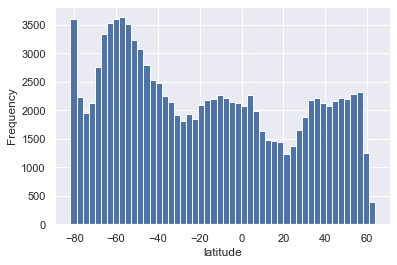

In [7]:
df['latitude'].plot(kind='hist',bins=50)

plt.xlabel('latitude')

plt.show()

Remove pixels with latitude > 70:

In [8]:
df = df.loc[ abs( df['latitude'] ) < 70]

print('dataframe shape',df.shape)

dataframe shape (101483, 113)


Gaussian processes are a "Lazy Learning" method (meaning that the training dataset will be used to make each new predictions). So it becomes slower with incrising the training dataset size. To avoid that, let's just take a smaller sample size: 

In [9]:
df = df.sample(n=10000, random_state = 42)
#df = df.sample(n=10000)
#df = df.head(n=10000)

In [10]:
df.shape

(10000, 113)

### Create cloud phase & multilayer cloud labels <a class="anchor" id="labels"></a>

Using the cldclass-lidar product (corresponding to cloud_layer_source = 3) in the dataset, let's define monolayer and multilayer clouds labels that will be used to train the machine learning algorithm:

In [11]:
df['label 1'] = 'unlabeled'
df['label 2'] = 'unlabeled'

#print(df.head())

for index, row in df.iterrows():
    nb_cloud_layer = 0
    cloud_phase_per_layer_list = []
    for layer_idx in range(10):
        if int( row['cloud_layer_source_{:02d}'.format(layer_idx+1)] ) == 3: # cldclass-lidar product
            cloud_phase_per_layer_list.append( int( row['cloud_layer_phase_{:02d}'.format(layer_idx+1)] ) )
            nb_cloud_layer = nb_cloud_layer + 1
    if nb_cloud_layer == 1: # monolayer cloud   
        df.loc[index,'label 1'] = 'monolayer (n=1)'
        if cloud_phase_per_layer_list[0] == 1: df.loc[index,'label 2'] = 'ice'
        if cloud_phase_per_layer_list[0] == 2: df.loc[index,'label 2'] = 'mixed'    
        if cloud_phase_per_layer_list[0] == 3: df.loc[index,'label 2'] = 'liquid'
    if nb_cloud_layer == 2: # multilayer cloud 
        df.loc[index,'label 1'] = 'multilayer (n=2)'
        if cloud_phase_per_layer_list[0] == 1 and cloud_phase_per_layer_list[1] == 1: 
            df.loc[index,'label 2'] = 'ice / ice'
        if cloud_phase_per_layer_list[0] == 1 and cloud_phase_per_layer_list[1] == 3: 
            df.loc[index,'label 2'] = 'ice / liquid'
        if cloud_phase_per_layer_list[0] == 1 and cloud_phase_per_layer_list[1] == 2: 
            df.loc[index,'label 2'] = 'ice / mixed'
        if cloud_phase_per_layer_list[0] == 3 and cloud_phase_per_layer_list[1] == 3: 
            df.loc[index,'label 2'] = 'liquid / liquid'
        if cloud_phase_per_layer_list[0] == 2 and cloud_phase_per_layer_list[1] == 3: 
            df.loc[index,'label 2'] = 'mixed / liquid'    
        if cloud_phase_per_layer_list[0] == 3 and cloud_phase_per_layer_list[1] == 1: 
            df.loc[index,'label 2'] = 'liquid / ice'
    if nb_cloud_layer > 2: # multilayer cloud 
        df.loc[index,'label 1'] = 'multilayer (n>2)'

In [12]:
df['label 1'].value_counts()

monolayer (n=1)     5842
multilayer (n=2)    2661
multilayer (n>2)    1079
unlabeled            418
Name: label 1, dtype: int64

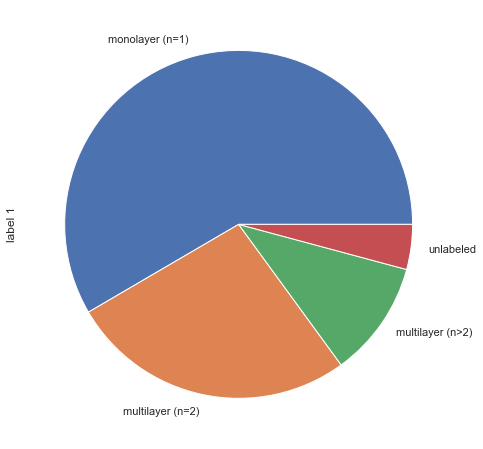

In [13]:
df['label 1'].value_counts().plot(kind='pie', figsize=(8, 8))

plt.show()

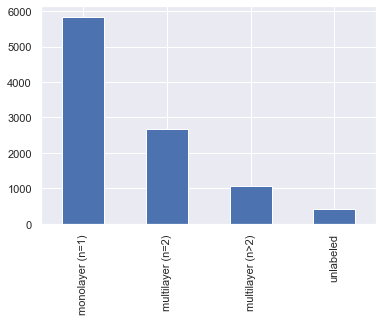

In [14]:
df['label 1'].value_counts().plot(kind='bar')

plt.show()

In [15]:
df['label 2'].value_counts()

liquid             2908
ice                1624
unlabeled          1560
mixed              1310
ice / liquid       1237
ice / mixed         479
ice / ice           452
liquid / liquid     271
mixed / liquid      151
liquid / ice          8
Name: label 2, dtype: int64

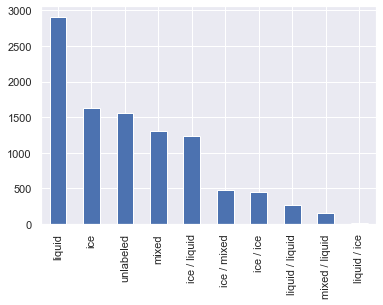

In [16]:
df['label 2'].value_counts().plot(kind='bar')

plt.show()

In [17]:
df.drop( df[(df['label 1'] == 'unlabeled' ) | (df['label 2'] == 'unlabeled')].index, inplace=True )

print(df.shape)

(8440, 115)


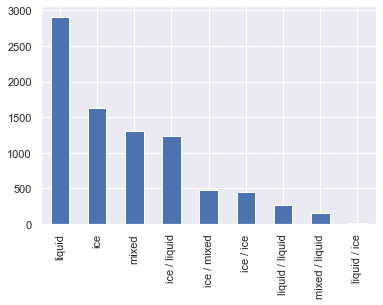

In [18]:
df['label 2'].value_counts().plot(kind='bar')

plt.savefig('output.png', bbox_inches='tight')
plt.show()

### Data Preparation (scaling and standardization) <a class="anchor" id="data_preparation"></a>

Create a function that prepare the data:

In [19]:
def data_preparation(df_train, df_test, max_train_sample_size, label_name, features_train):

    df_train_processed = df_train.copy()
    df_test_processed = df_test.copy()
    
    #----- data class balanced -----#    
    
    print(df_train_processed['label 2'].value_counts())
    
    df_train_processed['label 2'][ df_train_processed['label 2'] != label_name ] = '(not) ' + label_name
 
    df_train_processed['label 2'].value_counts().plot(kind='bar')

    plt.show()  

    #----- data class balanced -----#     
    
    # Separate majority and minority classes
    df_majority = df_train_processed[ df_train_processed['label 2'] != label_name ]
    df_minority = df_train_processed[ df_train_processed['label 2'] == label_name ]
    
    df_minority_len = len(df_minority)
    
    # Downsample majority class
    df_majority_downsampled = resample(df_majority, 
                                     replace=False,    # sample without replacement
                                     n_samples=df_minority_len,     # to match minority class
                                     random_state=123) # reproducible results

    # Combine minority class with downsampled majority class
    df_train_processed = pd.concat([df_majority_downsampled, df_minority])
    
    #print(df_train_processed)
    
    print(df_train_processed['label 2'].value_counts())

    df_train_processed['label 2'].value_counts().plot(kind='bar')

    plt.show() 
    
    #----- data train scaling -----#
    
    X_train = df_train_processed[features_train]

    scaler = preprocessing.StandardScaler().fit(X_train)

    X_train_scaled = scaler.transform(X_train)
    
    df_train_processed[features_train] = X_train_scaled
        
    #----- data test scaling -----#    
    
    X_test_scaled = scaler.transform(df_test_processed[features_train])
    
    df_test_processed[features_train] = X_test_scaled
    
    df_test_processed['label 2'][ df_test_processed['label 2'] != label_name ] = '(not) ' + label_name
    
    #----- data sub sampling -----#
    
    if df_minority_len * 2.0 > max_train_sample_size:

        df_majority = df_train_processed[ df_train_processed['label 2'] != label_name ]
        df_minority = df_train_processed[ df_train_processed['label 2'] == label_name ]    

        df_majority = df_majority.sample(n=int(max_train_sample_size/2.0), random_state=42)
        df_minority = df_minority.sample(n=int(max_train_sample_size/2.0), random_state=42)

        df_train_processed = pd.concat([df_majority, df_minority])

        df_train_processed['label 2'].value_counts().plot(kind='bar')

        plt.show()     

    return scaler, df_train_processed, df_test_processed

### Create a learning function<a class="anchor" id="learning_function"></a>

In [20]:
def train_gp_model(label_name, features_train, df_train_processed):
    
    kernel = C(1.0, (0.1, 10.0)) * RBF([0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2], (1e-2, 1e2))

    gp = GaussianProcessClassifier(kernel=kernel, n_restarts_optimizer=20)
    
    gp.fit(df_train_processed[features_train], df_train_processed['label 2'])
    
    return gp

### Create an evaluation function <a class="anchor" id="evaluation_function"></a>


In [21]:
def evaluate_gp_model(label_name, features_train, gp, df_test_processed):
        
    y_true = df_test_processed['label 2']
    y_pred = gp.predict_proba(df_test_processed[features_train])
    
    df_test_processed['label 2'].value_counts().plot(kind='bar')

    plt.show() 

    y_pred_list = []
    y_liq_liq_list = []
    y_liq_notliq_list = []
    y_notliq_liq_list = []
    y_notliq_notliq_list = []
    for i in range(y_pred.shape[0]):
        #print(y_pred[i,0],y_pred[i,1],y_true.iloc[i])
        if y_pred[i,0] >= 0.5:
            y_pred_list.append('(not) ' + label_name)
        else:
            y_pred_list.append(label_name)
        if y_true.iloc[i] == label_name:
            y_liq_liq_list.append(y_pred[i,1])
            y_liq_notliq_list.append(y_pred[i,0])  
        else:
            y_notliq_liq_list.append(y_pred[i,1])
            y_notliq_notliq_list.append(y_pred[i,0])                       
    
    print('accuracy_score:',accuracy_score(y_true, y_pred_list))  
    
    cm_data = confusion_matrix(y_true, y_pred_list) 

    #print(cm_data)
    
    label_list = ['(not) ' + label_name, label_name]
    label_list.sort()

    #df_cm = pd.DataFrame(100.0*cm_data/np.sum(cm_data), index = label_list, columns = label_list)

    #sns.heatmap(df_cm, annot=True)

    #plt.show()
    #plt.close()    
    
    plt.hist(y_liq_liq_list, alpha = 0.5, label=label_name)
    
    plt.hist(y_liq_notliq_list, alpha = 0.5, label='(not) ' + label_name)
    
    plt.title(label_name + ' -- True Label')
    
    plt.xlabel('Predicted Probability')
    plt.legend()
    
    plt.show()   
    
    plt.hist(y_notliq_liq_list, alpha = 0.5, label=label_name)
    
    plt.hist(y_notliq_notliq_list, alpha = 0.5, label='(not) ' + label_name)
    
    plt.title('(not) ' + label_name + ' -- True Label')
    
    plt.xlabel('Predicted Probability')
    
    plt.legend()
    
    plt.show()   
        
    fpr, tpr, _ = roc_curve(y_true, y_pred[:,1], pos_label=label_name)
    
    roc_auc = auc(fpr, tpr)
    plt.title('roc_auc = %0.2f' % roc_auc)
    
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    
    plt.show()

    #print('log_loss', log_loss(y_true, y_pred))

    return None

### Select MODIS bands that will be used to train the ML model <a class="anchor" id="selected_modis_band"></a>

In [22]:
features_train = ['modis_band_1','modis_band_7','modis_band_20',
                  'modis_band_26','modis_band_28','modis_band_29',
                  'modis_band_31','modis_band_32']

sub_df = df[features_train + ['label 1','label 2']]

### Split the dataset between a training and testing dataset:  <a class="anchor" id="create_train_and_test_dataset"></a>

In [23]:
df_train, df_test = train_test_split(sub_df, test_size = .3, random_state = 42)

print(df_train.shape)

(5908, 10)


### Train a model that detect monolayer liquid cloud <a class="anchor" id="monolayer_liquid"></a>

liquid             2064
ice                1124
mixed               900
ice / liquid        855
ice / mixed         333
ice / ice           331
liquid / liquid     193
mixed / liquid      103
liquid / ice          5
Name: label 2, dtype: int64


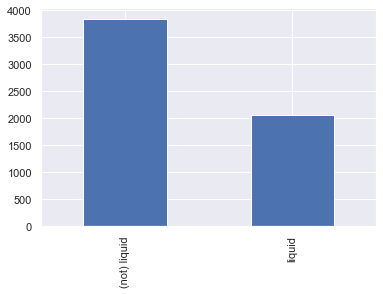

(not) liquid    2064
liquid          2064
Name: label 2, dtype: int64


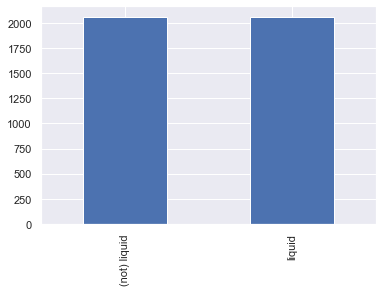

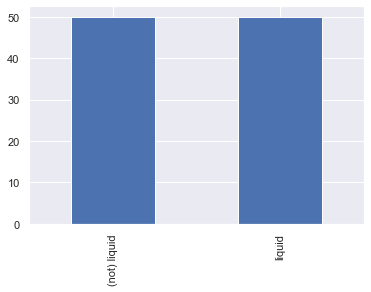

CPU times: user 334 ms, sys: 6.96 ms, total: 341 ms
Wall time: 339 ms


In [24]:
%%time

scaler_liquid, df_train_liquid_processed, df_test_liquid_processed = data_preparation(
                                            df_train, 
                                            df_test, 
                                            max_train_sample_size = 100, 
                                            label_name = 'liquid', features_train = features_train)

In [25]:
%%time

gp_liquid = train_gp_model('liquid', features_train, df_train_liquid_processed)

CPU times: user 4.8 s, sys: 32.8 ms, total: 4.83 s
Wall time: 2.5 s


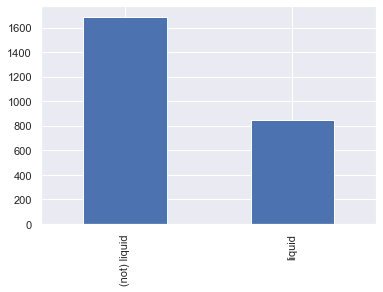

accuracy_score: 0.7729067930489731


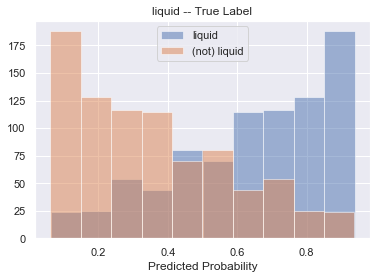

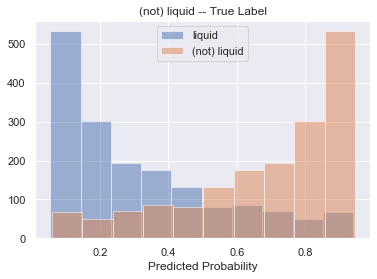

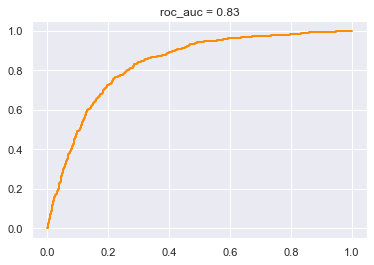

CPU times: user 1.01 s, sys: 14.5 ms, total: 1.02 s
Wall time: 817 ms


In [26]:
%%time

evaluate_gp_model('liquid', features_train, gp_liquid, df_test_liquid_processed)

### Train a model that detect monolayer ice cloud <a class="anchor" id="monolayer_ice"></a>

liquid             2064
ice                1124
mixed               900
ice / liquid        855
ice / mixed         333
ice / ice           331
liquid / liquid     193
mixed / liquid      103
liquid / ice          5
Name: label 2, dtype: int64


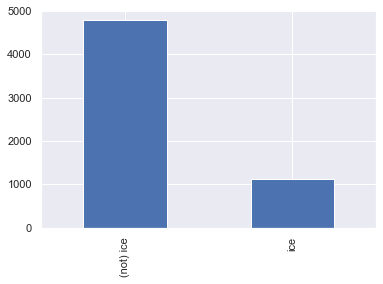

ice          1124
(not) ice    1124
Name: label 2, dtype: int64


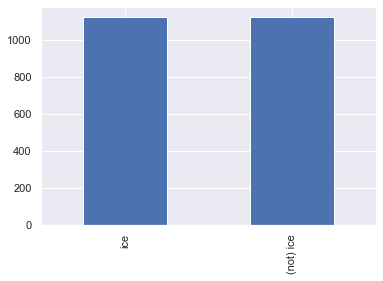

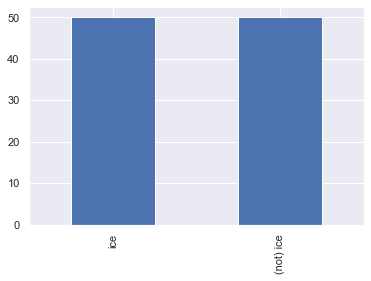

In [27]:
scaler_ice, df_train_ice_processed, df_test_ice_processed = data_preparation(
                                        df_train, 
                                        df_test, 
                                        max_train_sample_size = 100, 
                                        label_name = 'ice', features_train = features_train)

In [28]:
gp_ice = train_gp_model('ice', features_train, df_train_ice_processed)

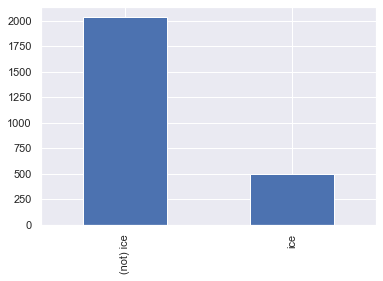

accuracy_score: 0.7417061611374408


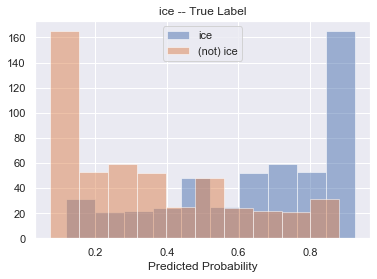

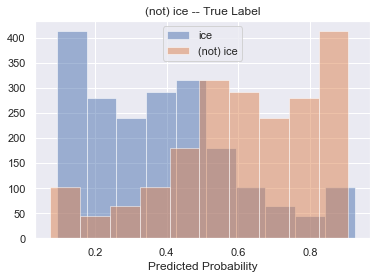

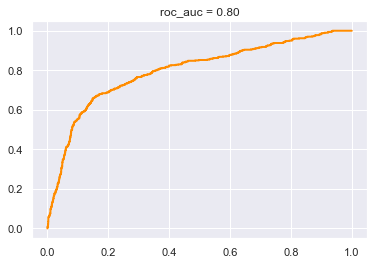

In [29]:
evaluate_gp_model('ice', features_train, gp_ice, df_test_ice_processed)

### Train a model that detect monolayer mixed cloud <a class="anchor" id="monolayer_mixed"></a>

liquid             2064
ice                1124
mixed               900
ice / liquid        855
ice / mixed         333
ice / ice           331
liquid / liquid     193
mixed / liquid      103
liquid / ice          5
Name: label 2, dtype: int64


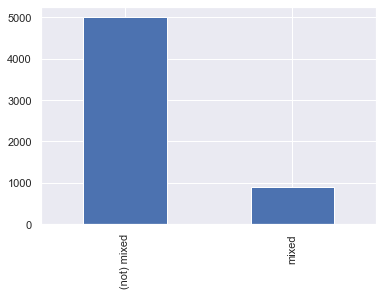

mixed          900
(not) mixed    900
Name: label 2, dtype: int64


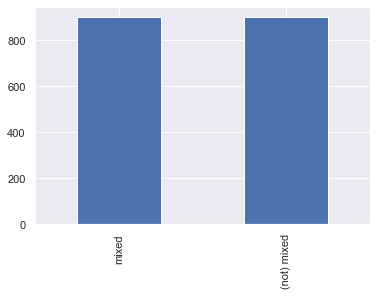

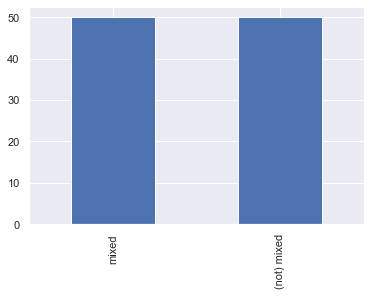

In [30]:
scaler_mixed, df_train_mixed_processed, df_test_mixed_processed = data_preparation(
                                        df_train, 
                                        df_test, 
                                        max_train_sample_size = 100, 
                                        label_name = 'mixed', features_train = features_train)

In [31]:
%%time

features_train = ['modis_band_1','modis_band_7','modis_band_20',
                  'modis_band_26','modis_band_28','modis_band_29',
                  'modis_band_31','modis_band_32']

gp_mixed = train_gp_model('mixed', features_train, df_train_mixed_processed)

CPU times: user 6.12 s, sys: 44.1 ms, total: 6.17 s
Wall time: 3.13 s


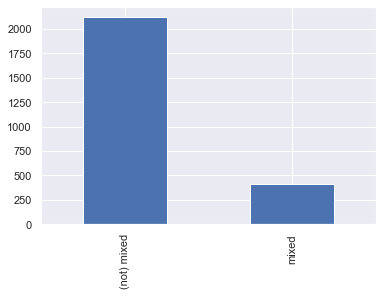

accuracy_score: 0.6303317535545023


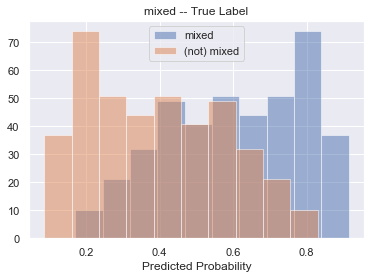

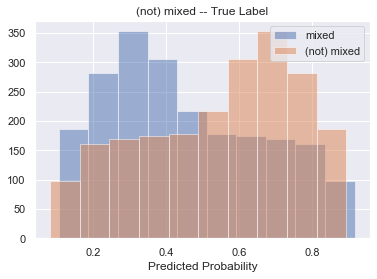

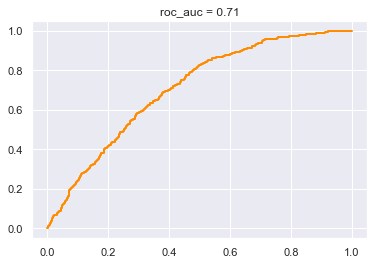

In [32]:
evaluate_gp_model('mixed', features_train, gp_mixed, df_test_mixed_processed)

### Train a model that detect multilayer (ice / liquid) cloud <a class="anchor" id="multilayer_ice_liquid"></a>

liquid             2064
ice                1124
mixed               900
ice / liquid        855
ice / mixed         333
ice / ice           331
liquid / liquid     193
mixed / liquid      103
liquid / ice          5
Name: label 2, dtype: int64


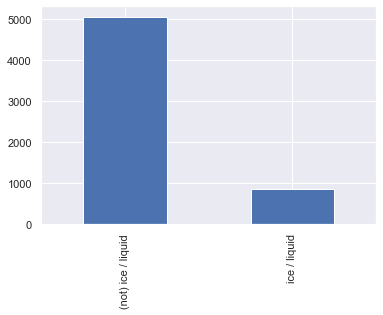

ice / liquid          855
(not) ice / liquid    855
Name: label 2, dtype: int64


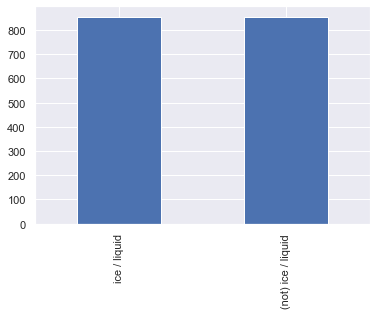

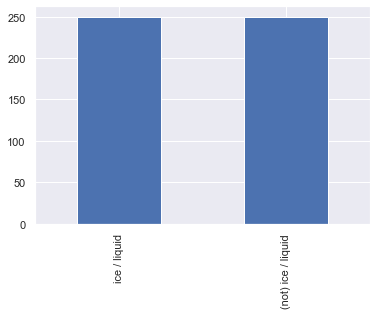

In [81]:
scaler_ice_over_liquid, df_train_ice_over_liquid_processed, df_test_ice_over_liquid_processed = data_preparation(
                                        df_train, 
                                        df_test, 
                                        max_train_sample_size = 500, 
                                        label_name = 'ice / liquid', features_train = features_train)

In [82]:
%%time

features_train = ['modis_band_1','modis_band_7','modis_band_20',
                  'modis_band_26','modis_band_28','modis_band_29',
                  'modis_band_31','modis_band_32']

gp_ice_over_liquid = train_gp_model('ice / liquid', features_train, df_train_ice_over_liquid_processed)

CPU times: user 2min 9s, sys: 8.84 s, total: 2min 18s
Wall time: 1min 9s


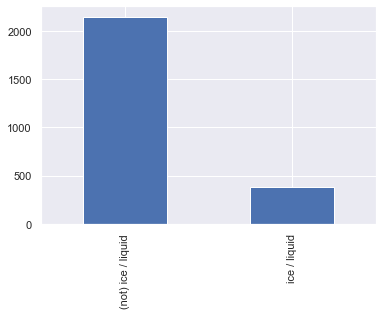

accuracy_score: 0.6184834123222749


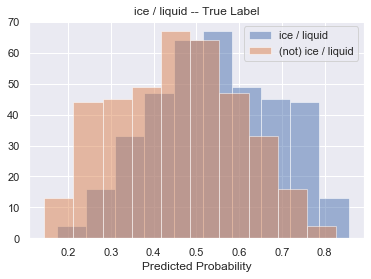

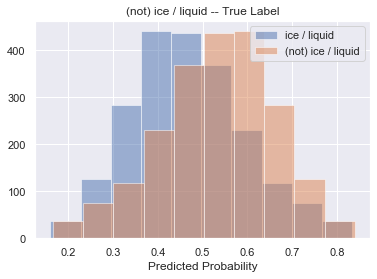

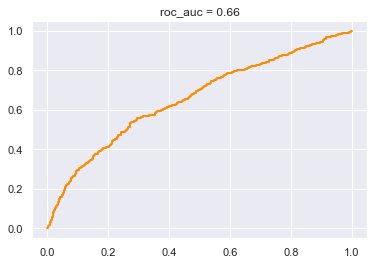

In [83]:
evaluate_gp_model('ice / liquid', features_train, gp_ice_over_liquid, df_test_ice_over_liquid_processed)

### Train a model that detect multilayer (ice / mixed) cloud <a class="anchor" id="multilayer_ice_mixed"></a>

liquid             2064
ice                1124
mixed               900
ice / liquid        855
ice / mixed         333
ice / ice           331
liquid / liquid     193
mixed / liquid      103
liquid / ice          5
Name: label 2, dtype: int64


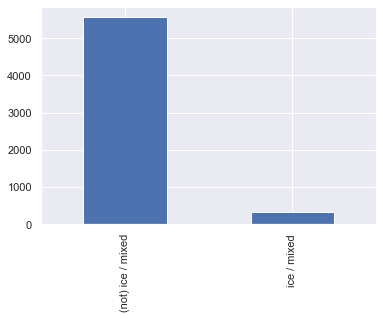

(not) ice / mixed    333
ice / mixed          333
Name: label 2, dtype: int64


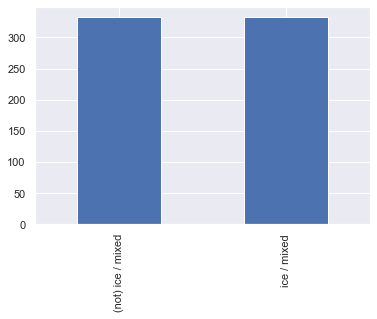

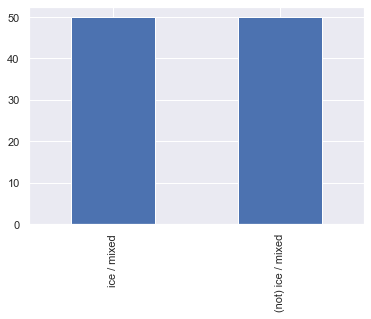

In [36]:
scaler_ice_over_mixed, df_train_ice_over_mixed_processed, df_test_ice_over_mixed_processed = data_preparation(
                                        df_train, 
                                        df_test, 
                                        max_train_sample_size = 100, 
                                        label_name = 'ice / mixed', features_train = features_train)

In [37]:
%%time

features_train = ['modis_band_1','modis_band_7','modis_band_20',
                  'modis_band_26','modis_band_28','modis_band_29',
                  'modis_band_31','modis_band_32']

gp_ice_over_mixed = train_gp_model('ice / mixed', features_train, df_train_ice_over_mixed_processed)

CPU times: user 5.66 s, sys: 59.6 ms, total: 5.71 s
Wall time: 3.07 s


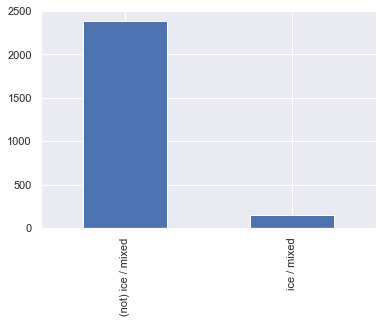

accuracy_score: 0.5217219589257504


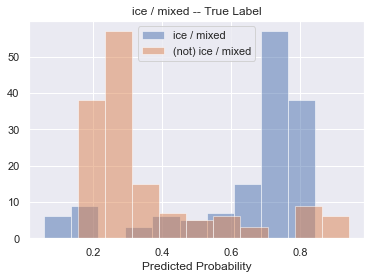

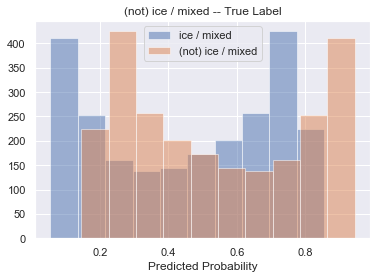

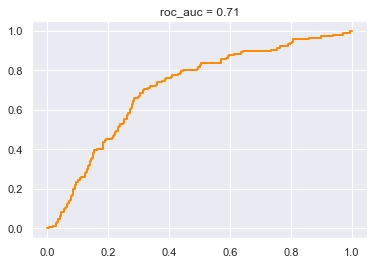

In [38]:
evaluate_gp_model('ice / mixed', features_train, gp_ice_over_mixed, df_test_ice_over_mixed_processed)

### Train a model that detect multilayer (ice / ice) cloud <a class="anchor" id="multilayer_ice_ice"></a>

liquid             2064
ice                1124
mixed               900
ice / liquid        855
ice / mixed         333
ice / ice           331
liquid / liquid     193
mixed / liquid      103
liquid / ice          5
Name: label 2, dtype: int64


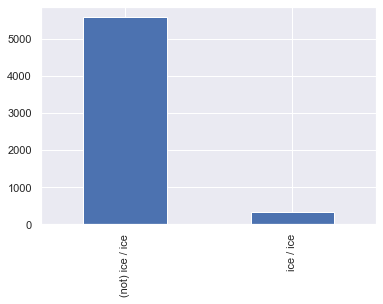

ice / ice          331
(not) ice / ice    331
Name: label 2, dtype: int64


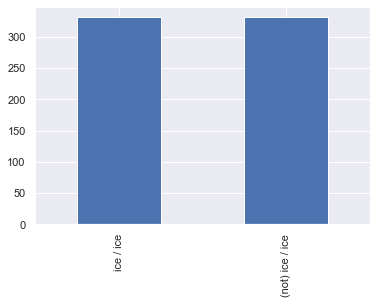

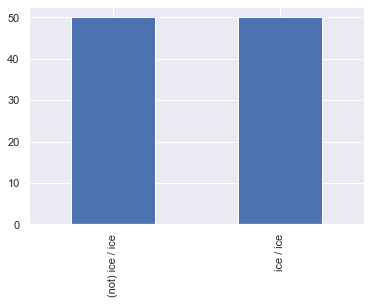

In [39]:
scaler_ice_over_ice, df_train_ice_over_ice_processed, df_test_ice_over_ice_processed = data_preparation(
                                        df_train, 
                                        df_test, 
                                        max_train_sample_size = 100, 
                                        label_name = 'ice / ice', features_train = features_train)

In [40]:
%%time

features_train = ['modis_band_1','modis_band_7','modis_band_20',
                  'modis_band_26','modis_band_28','modis_band_29',
                  'modis_band_31','modis_band_32']

gp_ice_over_ice = train_gp_model('ice / ice', features_train, df_train_ice_over_ice_processed)

CPU times: user 6.48 s, sys: 42.3 ms, total: 6.52 s
Wall time: 3.31 s


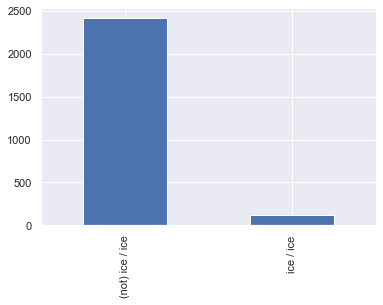

accuracy_score: 0.6212480252764613


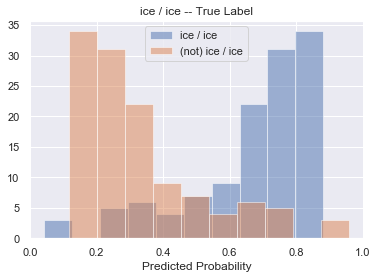

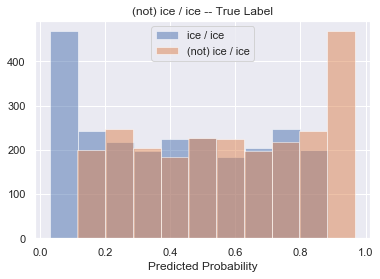

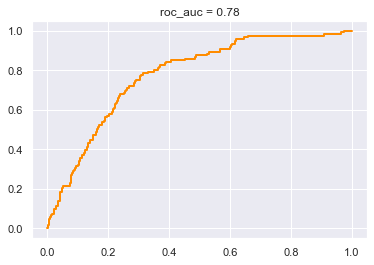

In [41]:
evaluate_gp_model('ice / ice', features_train, gp_ice_over_ice, df_test_ice_over_ice_processed)

### Train a model that detect multilayer (liquid / liquid) cloud <a class="anchor" id="multilayer_liquid_liquid"></a>

liquid             2064
ice                1124
mixed               900
ice / liquid        855
ice / mixed         333
ice / ice           331
liquid / liquid     193
mixed / liquid      103
liquid / ice          5
Name: label 2, dtype: int64


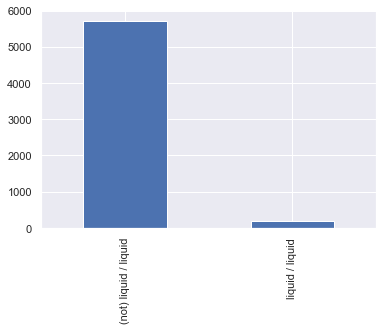

(not) liquid / liquid    193
liquid / liquid          193
Name: label 2, dtype: int64


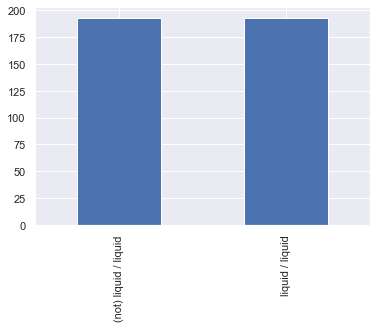

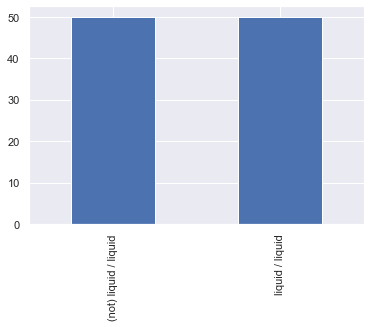

In [42]:
scaler_liquid_over_liquid, df_train_liq_over_liq_processed, df_test_liq_over_liq_processed = data_preparation(
                                        df_train, 
                                        df_test, 
                                        max_train_sample_size = 100, 
                                        label_name = 'liquid / liquid', features_train = features_train)

In [43]:
%%time

features_train = ['modis_band_1','modis_band_7','modis_band_20',
                  'modis_band_26','modis_band_28','modis_band_29',
                  'modis_band_31','modis_band_32']

gp_liq_over_liq = train_gp_model('liquid / liquid', features_train, df_train_liq_over_liq_processed)

CPU times: user 6.3 s, sys: 47.8 ms, total: 6.35 s
Wall time: 3.23 s


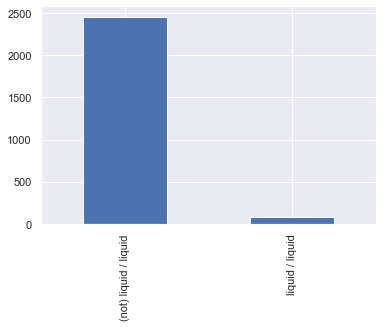

accuracy_score: 0.6015007898894155


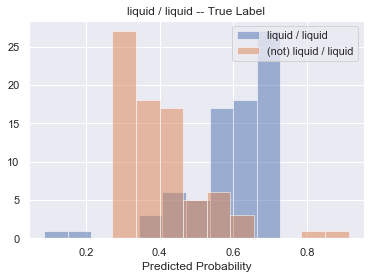

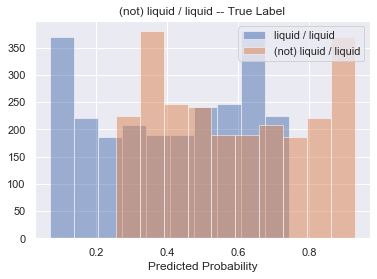

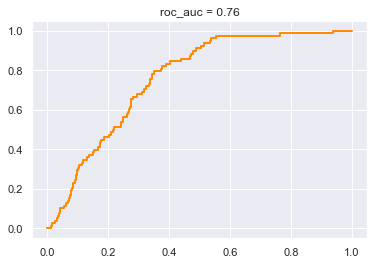

In [44]:
evaluate_gp_model('liquid / liquid', features_train, gp_liq_over_liq, df_test_liq_over_liq_processed)

### How to apply a machine learning model to a single MODIS granule ? <a class="anchor" id="modis_granule"></a>

In this section, we will see how to develop an algorihtm to apply previous ML models (based on Gaussian processes) to a single MODIS granule. For that we will use the following products: 

- MODIS MYD021KM L1
- MODIS MYD06 L2 Cloud Mask (to select only cloudy pixels to apply ML models)
- MODIS MYD06 L2 Cloud Phase (only to make some comparisons with the ML models)
- MODIS MYD06 L2 Multilayer Clouds (only to make some comparisons with the ML models)

In [84]:
myd021km_file = SD('../data/MYD021KM.A2008015.1435.006.2012066180438.hdf', SDC.READ)
myd06_file = SD('../data/MYD06_L2.A2008015.1435.006.2013342100940.hdf', SDC.READ)

Create a function to plot MODIS MYD06 L2 Cloud Mask:

In [46]:
def bits_stripping(bit_start,bit_count,value):
    bitmask=pow(2,bit_start+bit_count)-1
    return np.right_shift(np.bitwise_and(value,bitmask),bit_start)

def plot_MODIS_L2_Cloud_Mask_1km(cloud_mask_flag):
    figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
    #cmap =  [(1.0,1.0,1.0)] + [(1.0, 0.0, 0.0)] + [(65.0/255,105.0/255,225.0/255)] + [(0.0,0.0,0.0)]
    #cmap = sns.mpl_palette("Set1", 4)
    cmap = sns.color_palette("RdBu", n_colors=4)
    cmap = mpl.colors.ListedColormap(cmap)
    bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    img = plt.imshow(np.fliplr(cloud_mask_flag), cmap=cmap, norm=norm,interpolation='none', origin='lower')
    cbar_bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]
    cbar_ticks = [ 0, 1, 2, 3]  
    cbar_labels = ['Confident Cloudy', 'Probably Cloudy','Probably Clear ','Confident Clear']  
    cbar = plt.colorbar(img, cmap=cmap, norm=norm, boundaries=cbar_bounds, ticks=cbar_ticks)
    cbar.ax.set_yticklabels(cbar_labels, fontsize=11)
    plt.title('MODIS MYD06 C6 Cloud Mask 1km', fontsize=11)
    l = [int(i) for i in np.linspace(0,data.shape[1],6)]
    plt.xticks(l, [i for i in reversed(l)], rotation=0, fontsize=11 )
    l = [int(i) for i in np.linspace(0,data.shape[0],9)]
    plt.yticks(l, l, rotation=0, fontsize=11 )
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.show()

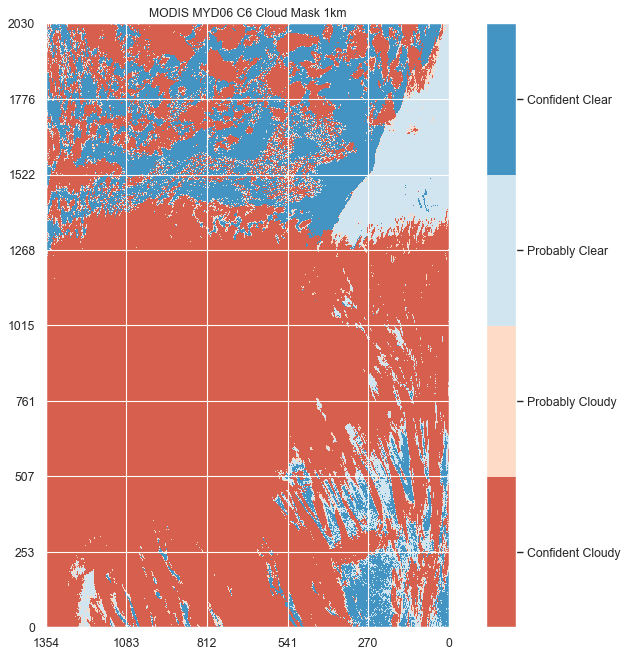

In [47]:
data_selected_id = myd06_file.select('Cloud_Mask_1km')
data = data_selected_id.get()   
cloud_mask_flag = bits_stripping(1,2,data[:,:,0])
plot_MODIS_L2_Cloud_Mask_1km(cloud_mask_flag)  

Create a function to plot MODIS MYD06 L2 Cloud Phase:

In [48]:
def plot_MODIS_L2_Cloud_Phase_Optical_Properties(data):
    figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
    cmap = sns.color_palette("RdBu_r", n_colors=4)
    cmap = mpl.colors.ListedColormap(cmap)
    bounds = [-0.5, 1.5, 2.5, 3.5, 4.5]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    img = plt.imshow(np.fliplr(data), cmap=cmap, norm=norm,interpolation='none', origin='lower')
    cbar_bounds = [0.5,1.5, 2.5, 3.5, 4.5]
    cbar_ticks = [1.0,2.0,3.0,4.0]  
    cbar_labels = ['clear','Liquid','Ice','Und.']  
    cbar = plt.colorbar(img, cmap=cmap, norm=norm, boundaries=cbar_bounds, ticks=cbar_ticks)
    cbar.ax.set_yticklabels(cbar_labels, fontsize=10)
    plt.title('MODIS MYD06 C6 \n Cloud Phase Optical Properties', fontsize=11)
    l = [int(i) for i in np.linspace(0,data.shape[1],6)]
    plt.xticks(l, [i for i in reversed(l)], rotation=0, fontsize=11 )
    l = [int(i) for i in np.linspace(0,data.shape[0],9)]
    plt.yticks(l, l, rotation=0, fontsize=11 )
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.show()

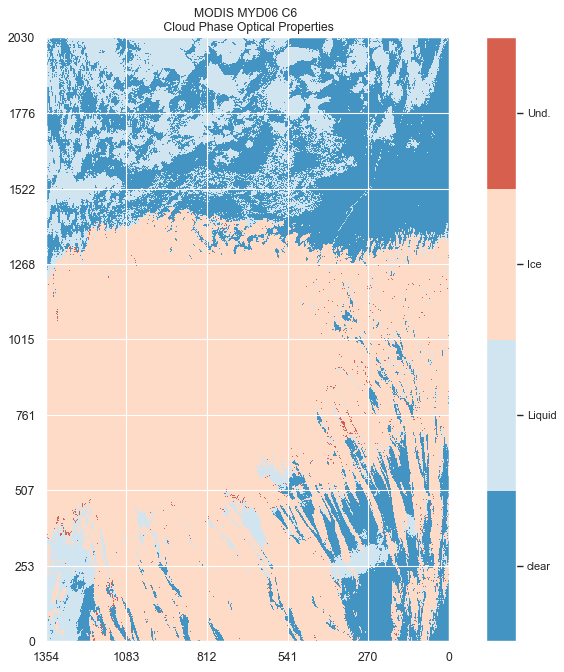

In [49]:
data_selected_id = myd06_file.select('Cloud_Phase_Optical_Properties')
data = data_selected_id.get()
plot_MODIS_L2_Cloud_Phase_Optical_Properties(data)   

Create a function to plot MODIS MYD06 L2 Multilayer Clouds:

In [50]:
def plot_multilayer_clouds(data):
    figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
    cmap = sns.color_palette('RdBu_r', n_colors=10)
    cmap = mpl.colors.ListedColormap(cmap)
    bounds = [-0.5, 1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    img = plt.imshow(np.fliplr(data), cmap=cmap, norm=norm,interpolation='none', origin='lower')
    cbar_bounds = [-0.5,0.5, 1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5]
    cbar_ticks = [0,1,2,3,4,5,6,7,8,9]               
    cbar = plt.colorbar(img, cmap=cmap, norm=norm, boundaries=cbar_bounds, ticks=cbar_ticks)
    cbar.ax.set_yticklabels(cbar_ticks, fontsize=10)
    plt.title('MODIS MYD06 C6 \n Multilayer Clouds', fontsize=11)
    l = [int(i) for i in np.linspace(0,data.shape[1],6)]
    plt.xticks(l, [i for i in reversed(l)], rotation=0, fontsize=11 )
    l = [int(i) for i in np.linspace(0,data.shape[0],9)]
    plt.yticks(l, l, rotation=0, fontsize=11 )
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.show()

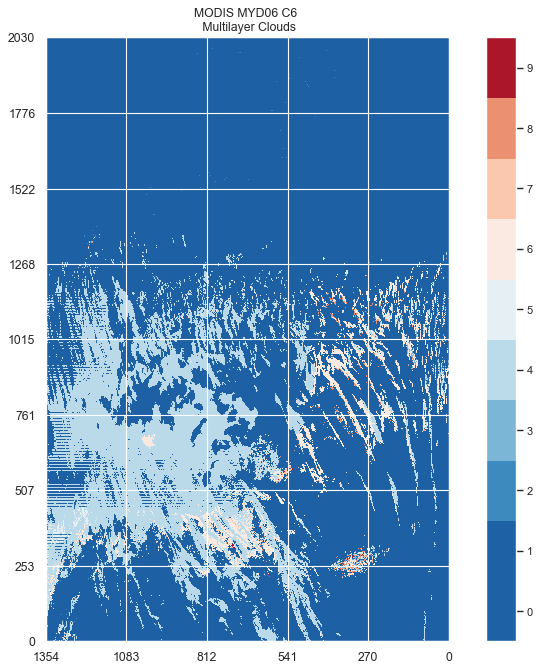

In [51]:
data_selected_id = myd06_file.select('Cloud_Multi_Layer_Flag')

data = data_selected_id.get()
data_selected_attributes = data_selected_id.attributes()
plot_multilayer_clouds(data)

Read and create a function to plot MODIS MYD021KM L1:

In [52]:
EV_250_Aggr1km_RefSB = myd021km_file.select('EV_250_Aggr1km_RefSB')
EV_500_Aggr1km_RefSB = myd021km_file.select('EV_500_Aggr1km_RefSB')
EV_1KM_RefSB = myd021km_file.select('EV_1KM_RefSB')
EV_1KM_Emissive = myd021km_file.select('EV_1KM_Emissive')

First, lets create a dictionary that will store for each MODIS band the corresponding SDS name and index: 

In [53]:
modis_band_dic = {}

In [54]:
#print( EV_250_Aggr1km_RefSB.info() )
EV_250_Aggr1km_RefSB_attributes = EV_250_Aggr1km_RefSB.attributes()
EV_250_Aggr1km_RefSB_scales = EV_250_Aggr1km_RefSB_attributes['reflectance_scales']
EV_250_Aggr1km_RefSB_offsets = EV_250_Aggr1km_RefSB_attributes['reflectance_offsets']
#pprint.pprint(EV_250_Aggr1km_RefSB_attributes )

for idx,i in enumerate(EV_250_Aggr1km_RefSB_attributes['band_names'].split(',')):
    print(idx,i)    
    modis_band_dic[i] = [EV_250_Aggr1km_RefSB,idx]

0 1
1 2


In [55]:
#print( EV_500_Aggr1km_RefSB.info() )
EV_500_Aggr1km_RefSB_attributes = EV_500_Aggr1km_RefSB.attributes()
EV_500_Aggr1km_RefSB_scales = EV_500_Aggr1km_RefSB_attributes['reflectance_scales']
EV_500_Aggr1km_RefSB_offsets = EV_500_Aggr1km_RefSB_attributes['reflectance_offsets']
#pprint.pprint(EV_500_Aggr1km_RefSB_attributes )

for idx,i in enumerate(EV_500_Aggr1km_RefSB_attributes['band_names'].split(',')):
    print(idx,i)
    modis_band_dic[i] = [EV_500_Aggr1km_RefSB,idx]

0 3
1 4
2 5
3 6
4 7


In [56]:
#print( EV_1KM_RefSB.info() )
EV_1KM_RefSB_attributes = EV_1KM_RefSB.attributes()
EV_1KM_RefSB_scales = EV_1KM_RefSB_attributes['reflectance_scales']
EV_1KM_RefSB_offsets = EV_1KM_RefSB_attributes['reflectance_offsets']
#pprint.pprint(EV_1KM_RefSB_attributes )

for idx,i in enumerate(EV_1KM_RefSB_attributes['band_names'].split(',')):
    print(idx,i)
    modis_band_dic[i] = [EV_1KM_RefSB,idx]

0 8
1 9
2 10
3 11
4 12
5 13lo
6 13hi
7 14lo
8 14hi
9 15
10 16
11 17
12 18
13 19
14 26


In [57]:
print( EV_1KM_Emissive.info() )
EV_1KM_Emissive_attributes = EV_1KM_Emissive.attributes()
EV_1KM_Emissive_scales = EV_1KM_Emissive_attributes['radiance_scales']
EV_1KM_Emissive_offsets = EV_1KM_Emissive_attributes['radiance_offsets']
#pprint.pprint(EV_1KM_Emissive_attributes )

for idx,i in enumerate(EV_1KM_Emissive_attributes['band_names'].split(',')):
    print(idx,i)
    modis_band_dic[i] = [EV_1KM_Emissive,idx]

('EV_1KM_Emissive', 3, [16, 2030, 1354], 23, 8)
0 20
1 21
2 22
3 23
4 24
5 25
6 27
7 28
8 29
9 30
10 31
11 32
12 33
13 34
14 35
15 36


In [58]:
for key in modis_band_dic:
    print(key, modis_band_dic[key][0].info()[0], modis_band_dic[key][1])

1 EV_250_Aggr1km_RefSB 0
2 EV_250_Aggr1km_RefSB 1
3 EV_500_Aggr1km_RefSB 0
4 EV_500_Aggr1km_RefSB 1
5 EV_500_Aggr1km_RefSB 2
6 EV_500_Aggr1km_RefSB 3
7 EV_500_Aggr1km_RefSB 4
8 EV_1KM_RefSB 0
9 EV_1KM_RefSB 1
10 EV_1KM_RefSB 2
11 EV_1KM_RefSB 3
12 EV_1KM_RefSB 4
13lo EV_1KM_RefSB 5
13hi EV_1KM_RefSB 6
14lo EV_1KM_RefSB 7
14hi EV_1KM_RefSB 8
15 EV_1KM_RefSB 9
16 EV_1KM_RefSB 10
17 EV_1KM_RefSB 11
18 EV_1KM_RefSB 12
19 EV_1KM_RefSB 13
26 EV_1KM_RefSB 14
20 EV_1KM_Emissive 0
21 EV_1KM_Emissive 1
22 EV_1KM_Emissive 2
23 EV_1KM_Emissive 3
24 EV_1KM_Emissive 4
25 EV_1KM_Emissive 5
27 EV_1KM_Emissive 6
28 EV_1KM_Emissive 7
29 EV_1KM_Emissive 8
30 EV_1KM_Emissive 9
31 EV_1KM_Emissive 10
32 EV_1KM_Emissive 11
33 EV_1KM_Emissive 12
34 EV_1KM_Emissive 13
35 EV_1KM_Emissive 14
36 EV_1KM_Emissive 15


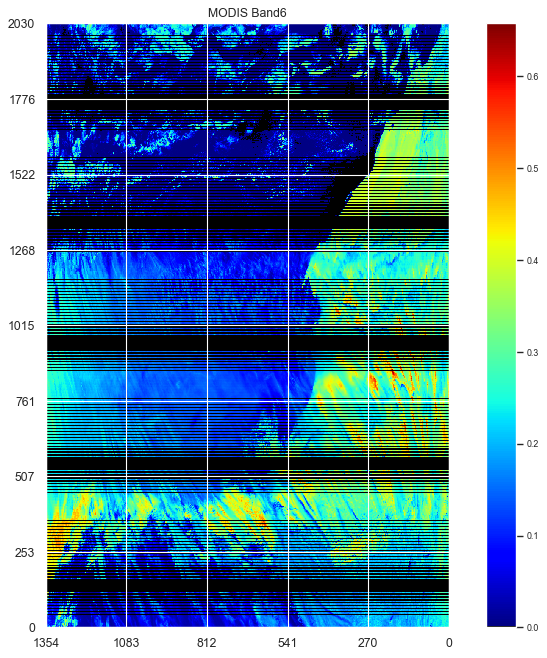

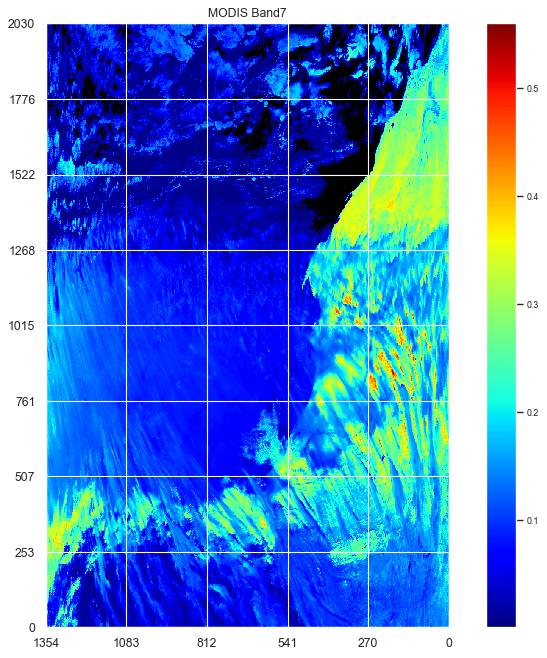

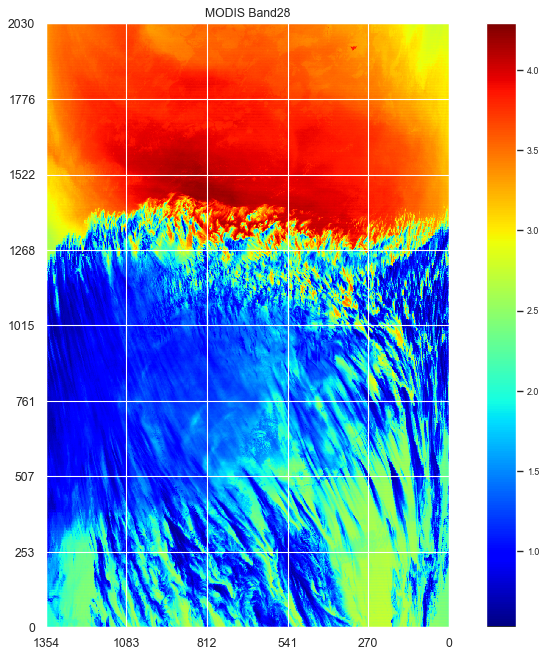

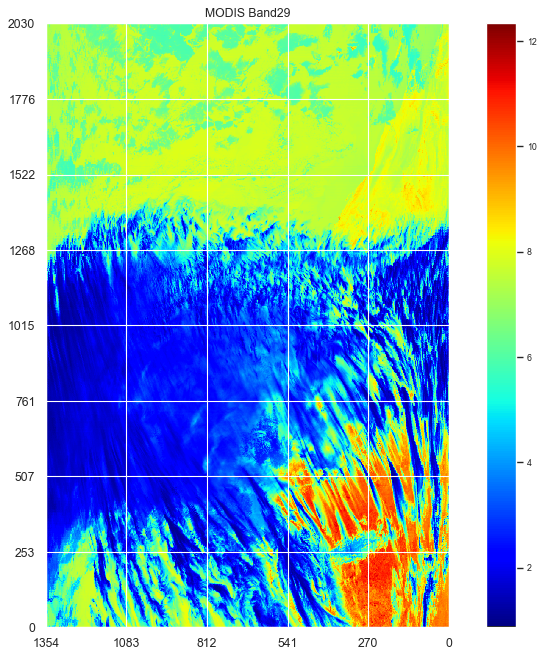

In [59]:
def plot_MODIS_L1(MODIS_band, modis_band_dic):

    data_selected_id = modis_band_dic[str(MODIS_band)][0]
    band_idx = modis_band_dic[str(MODIS_band)][1]
    title = 'MODIS Band' + str(MODIS_band)
    
    figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

    data = data_selected_id.get()
    data_selected_band = data[band_idx,:,:]
    data_selected_attributes = data_selected_id.attributes()
    _FillValue = data_selected_attributes['_FillValue']
    _FillValue = 65528 # warning wrong _FillValue stored in attributes    

    if modis_band_dic[str(MODIS_band)][0].info()[0] == 'EV_1KM_Emissive':
    
        radiance_scales = data_selected_attributes['radiance_scales']
        radiance_offsets = data_selected_attributes['radiance_offsets']
        data_selected_band[ data_selected_band == _FillValue ] = 0.0
        data_selected_band = (data_selected_band - radiance_offsets[band_idx]) * radiance_scales[band_idx]    
    
    else:
    
        reflectance_scales = data_selected_attributes['reflectance_scales']
        data_selected_band[ data_selected_band == _FillValue ] = 0.0
        data_selected_band = data_selected_band * reflectance_scales[band_idx]

    cmap = [(0.0,0.0,0.0)] + [(cm.jet(i)) for i in range(1,256)] 
    cmap = mpl.colors.ListedColormap(cmap)
    img = plt.imshow(np.fliplr(data_selected_band), cmap=cmap,interpolation='none', origin='lower')
    plt.title(title, fontsize=11)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=8)
    l = [int(i) for i in np.linspace(0,data_selected_band.shape[1],6)]
    plt.xticks(l, [i for i in reversed(l)], rotation=0, fontsize=11 )
    l = [int(i) for i in np.linspace(0,data_selected_band.shape[0],9)]
    plt.yticks(l, l, rotation=0, fontsize=11 )
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)    
    plt.show()
    
plot_MODIS_L1(6,modis_band_dic)
plot_MODIS_L1(7,modis_band_dic)
plot_MODIS_L1(28,modis_band_dic)
plot_MODIS_L1(29,modis_band_dic)

Now let's see how to apply ML models created previously to all cloudy pixels of a single MODIS granule. For that we will vectorize the MODIS cloudy pixels (instead of creating a for loop on every granule pixels which will be quite slow).

First, let's create a function that select only cloudy or probably cloudy pixels:

In [60]:
A = np.argwhere( cloud_mask_flag < 2 ) # cloudy pixels
row = A[:,0]
col = A[:,1]

def select_cloudy_pixel_only(data):
    data_masked = ma.masked_where( cloud_mask_flag > 1, data)
    return np.ma.compressed(data_masked)

Get the MODIS L1 data:

In [61]:
EV_250_Aggr1km_RefSB_data = EV_250_Aggr1km_RefSB.get()
EV_500_Aggr1km_RefSB_data = EV_500_Aggr1km_RefSB.get()
EV_1KM_RefSB_data = EV_1KM_RefSB.get()
EV_1KM_Emissive_data = EV_1KM_Emissive.get()

In [62]:
def vectorize_modis_l1(features_train, modis_band_dic):
    
    X_list = []
    
    for feature in features_train:
    
        modis_band = feature.replace('modis_band_','')  
        modis_band_idx = modis_band_dic[modis_band][1]
        
        if modis_band_dic[modis_band][0].info()[0] == 'EV_250_Aggr1km_RefSB':
            data_band = EV_250_Aggr1km_RefSB_data[modis_band_idx,:,:]
            data_band = (data_band - EV_250_Aggr1km_RefSB_offsets[modis_band_idx]) * EV_250_Aggr1km_RefSB_scales[modis_band_idx]
  
        if modis_band_dic[modis_band][0].info()[0] == 'EV_500_Aggr1km_RefSB':
            data_band = EV_500_Aggr1km_RefSB_data[modis_band_idx,:,:]
            data_band = (data_band - EV_500_Aggr1km_RefSB_offsets[modis_band_idx]) * EV_500_Aggr1km_RefSB_scales[modis_band_idx]
            
        if modis_band_dic[modis_band][0].info()[0] == 'EV_1KM_RefSB':
            data_band = EV_1KM_RefSB_data[modis_band_idx,:,:]
            data_band = (data_band - EV_1KM_RefSB_scales[modis_band_idx]) * EV_1KM_RefSB_scales[modis_band_idx]
            
        if modis_band_dic[modis_band][0].info()[0] == 'EV_1KM_Emissive':
            data_band = EV_1KM_Emissive_data[modis_band_idx,:,:] 
            data_band = (data_band - EV_1KM_Emissive_offsets[modis_band_idx]) * EV_1KM_Emissive_scales[modis_band_idx]

        X_list.append( select_cloudy_pixel_only(data_band) )
        
    return np.stack(X_list, axis=-1)

In [63]:
features_train = ['modis_band_1','modis_band_7','modis_band_20',
                  'modis_band_26','modis_band_28','modis_band_29',
                  'modis_band_31','modis_band_32']

X = vectorize_modis_l1(features_train, modis_band_dic)

print(X.shape)

(2016074, 8)


In [64]:
X_scaled = scaler_liquid.transform(X)

In [65]:
%%time

gp_liquid_y_prob = gp_liquid.predict_proba(X_scaled)

CPU times: user 8.28 s, sys: 3.01 s, total: 11.3 s
Wall time: 9.97 s


In [69]:
def plot_y_prob(data, title):
    figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
    cmap = sns.color_palette("RdBu_r", n_colors=10)
    cmap = mpl.colors.ListedColormap(cmap)
    img = plt.imshow(np.fliplr(data), cmap=cmap,interpolation='none', origin='lower', vmin=0.0, vmax=1.0)
    cbar = plt.colorbar(img, cmap=cmap)
    plt.title(title, fontsize=16)
    l = [int(i) for i in np.linspace(0,data.shape[1],6)]
    plt.xticks(l, [i for i in reversed(l)], rotation=0, fontsize=11 )
    l = [int(i) for i in np.linspace(0,data.shape[0],9)]
    plt.yticks(l, l, rotation=0, fontsize=11 )
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.show()

In [74]:
l = ['liquid', '(not) liquid']
l.sort()

print(l)

['(not) liquid', 'liquid']


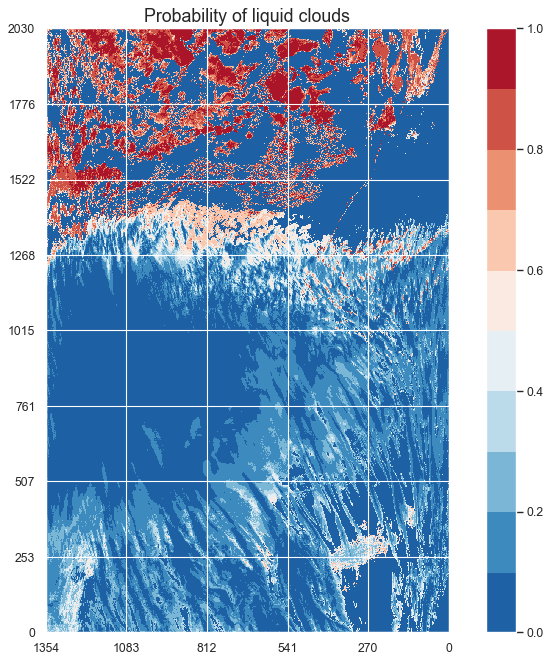

In [75]:
modis_y_prob = np.zeros((cloud_mask_flag.shape)) 
modis_y_prob[row,col] = gp_liquid_y_prob[:,1]
plot_y_prob(modis_y_prob, 'Probability of liquid clouds')

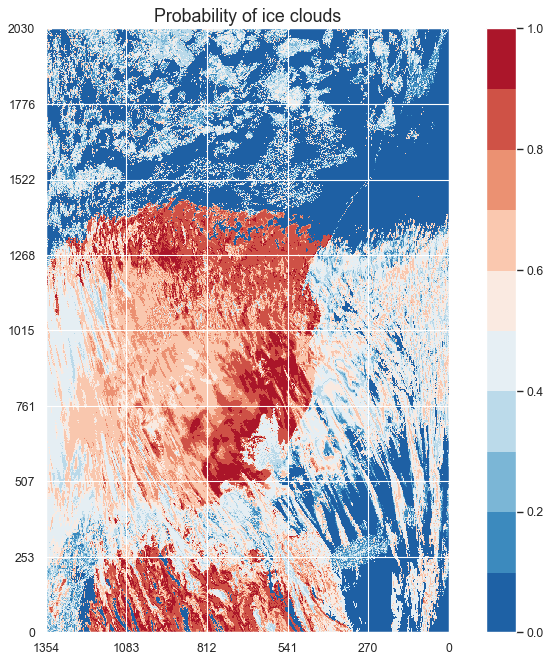

In [76]:
X_scaled = scaler_ice.transform(X)

gp_ice_y_prob = gp_ice.predict_proba(X_scaled)

modis_y_prob = np.zeros((cloud_mask_flag.shape)) 
modis_y_prob[row,col] = gp_ice_y_prob[:,1]

plot_y_prob(modis_y_prob, 'Probability of ice clouds')

### Conclusions <a class="anchor" id="conclusions"></a>

In this notebook, I summarized my first attempt of using machine learning Gaussian processes to develop a cloud phase and multilayer cloud classification algorithm for MODIS. GP give good results on the training and test datasets. Unfortunetly it appears that it is not the best approach to use in production since Gaussian processes approach becomes very slow when the size of the training dataset increases (which will be necessary if I want to add new input features such the surface type, more MODIS bands, etc). So

What are the pro(s) of Gaussian Processes ?

- Easy to train (not a lot of hyperparamters)

What are the con(s) of Gaussian Processes ?

- Very slow to make a new prediction ('lazy learning': use the entire training dataset to make a prediction)

What do we learned ?

Even if GP is not the best suited approach, I learned a bunch of things that will be used in the future notebooks:

- cloud phase and mutlialyer cloud classification is a multi-label problem not a multi-class problem (1 vs all strategy not 1 vs 1 to train ML models).
- how to scale and homogenize the data.
- how to vectorize MODIS cloudy pixels to apply a ML model.

What is the next step ?

- I will try the same approach but using a deep neural network instead, that will be presented in the next jupyter notebook. 
